In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_excel('Online_Retail.xlsx')
df = df[df['CustomerID'].notna()]

df_fix = df.sample(10000, random_state = 42)

In [3]:
# Convert to show date only
from datetime import datetime
df_fix["InvoiceDate"] = df_fix["InvoiceDate"].dt.date
# Create TotalSum colummn
df_fix["TotalSum"] = df_fix["Quantity"] * df_fix["UnitPrice"]
# Create date variable that records recency
import datetime
snapshot_date = max(df_fix.InvoiceDate) + datetime.timedelta(days=1)
# Aggregate data by each customer
customers = df_fix.groupby(['CustomerID']).agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'count',
    'TotalSum': 'sum'})
# Rename columns
customers.rename(columns = {'InvoiceDate': 'Recency',
                            'InvoiceNo': 'Frequency',
                            'TotalSum': 'Monetary'}, inplace=True)

In [4]:
from scipy import stats
customers_RFM = pd.DataFrame()
customers_RFM["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_RFM["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_RFM["Monetary"] = pd.Series(np.cbrt(customers['Monetary'])).values
customers_RFM.tail()

,Recency,Frequency,Monetary
2685,7.832068,0.591193,3.408514
2686,1.269495,1.435599,5.907565
2687,4.288385,0.591193,-1.669108
2688,1.665555,1.615329,4.273206
2689,6.340700,1.017445,4.087250


In [5]:
# Import library
from sklearn.preprocessing import StandardScaler
# Initialize the Object
scaler = StandardScaler()
# Fit and Transform The Data
scaler.fit(customers_RFM)
normalized_customers = scaler.transform(customers_RFM)


In [6]:
!pip install seaborn

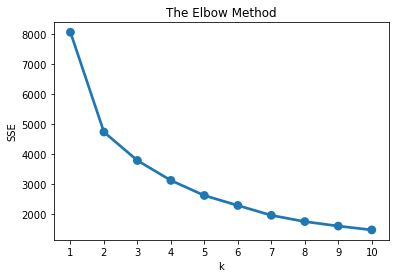

In [7]:
from sklearn.cluster import KMeans
import seaborn as sns

sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(normalized_customers)
    sse[k] = kmeans.inertia_ # SSE to closest cluster centroid
plt.title('The Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

In [8]:
model = KMeans(n_clusters=3, random_state=42)
model.fit(normalized_customers)
model.labels_.shape

(2690,)

In [9]:
customers["Cluster"] = model.labels_
customers.groupby('Cluster').agg({
    'Recency':'mean',
    'Frequency':'mean',
    'Monetary':['mean', 'count']}).round(2)

Recency Frequency Monetary      
           mean      mean     mean count
Cluster                                 
0         46.25      7.71   165.79   924
1         47.62      1.61    21.51   811
2        227.29      1.64    28.70   955

C:\Users\junzh\.conda\envs\es\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Attribute', ylabel='Value'>

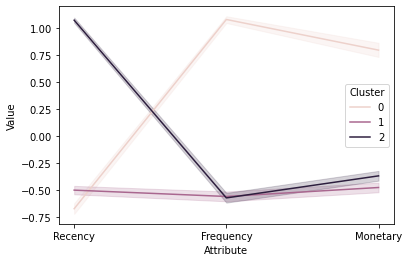

In [14]:
# Create the dataframe
customers_normalized = pd.DataFrame(normalized_customers, columns=['Recency', 'Frequency', 'Monetary'])
customers_normalized['ID'] = customers.index
customers_normalized['Cluster'] = model.labels_
# Melt The Data
df_nor_melt = pd.melt(customers_normalized.reset_index(),
                      id_vars=['ID', 'Cluster'],
                      value_vars=['Recency','Frequency','Monetary'],
                      var_name='Attribute',
                      value_name='Value')
df_nor_melt.head()
# Visualize it
sns.lineplot('Attribute', 'Value', hue='Cluster', data=df_nor_melt)

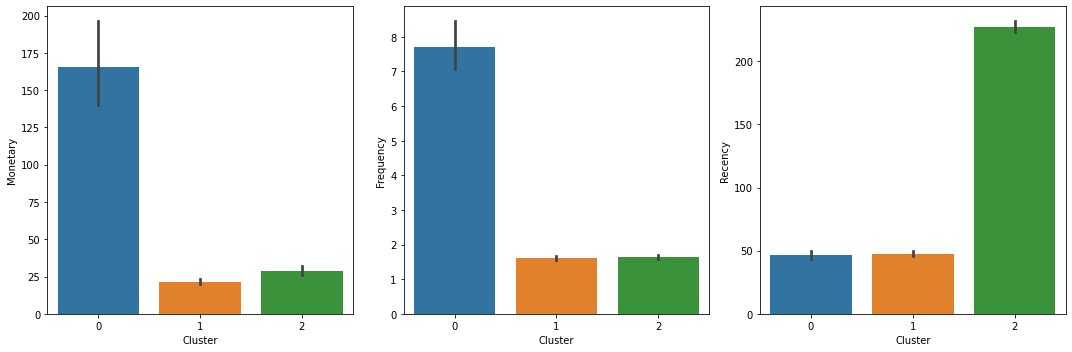

In [15]:
fig, axs = plt.subplots(1,3, figsize = (15,5))

sns.barplot(x=customers.Cluster, y=customers.Monetary, ax = axs[0])
sns.barplot(x=customers.Cluster, y=customers.Frequency, ax = axs[1])
sns.barplot(x=customers.Cluster, y=customers.Recency, ax = axs[2])
plt.tight_layout()            
plt.show()